In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

In [2]:
SEED = 265
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## 2 Object Localization
#### First we load and inspect the localization_*** datasets

In [3]:
train_data = torch.load('data/localization_train.pt')
val_data = torch.load('data/localization_val.pt')
test_data = torch.load('data/localization_test.pt')

In [4]:
print(f'Train data size: {len(train_data)}')
print(f'Val data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 59400
Val data size: 6600
Test data size: 11000


In [5]:
first_img, first_label = train_data[0]

print(f'Shape of first image: {first_img.shape}')
print(f'Type of first image: {type(first_img)}')

print(f'\nShape of first label: {first_label.shape}')
print(f'Type of first label: {type(first_label)})')
first_label

Shape of first image: torch.Size([1, 48, 60])
Type of first image: <class 'torch.Tensor'>

Shape of first label: torch.Size([6])
Type of first label: <class 'torch.Tensor'>)


tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000], dtype=torch.float32)

In [6]:
def count_instances(data, data_name=None) -> None:
    """Counts the number of instances of each class in a dataset"""
    counter = Counter([int(label[-1]) for _, label in data])
    sorted_counter = dict(sorted(counter.items()))
    if data_name is not None:
        print(f'Class distribution in {data_name}')
    for key, value in sorted_counter.items():
        print(f'{key}: {value}')

count_instances(train_data, 'Training Data')
count_instances(val_data, 'Validation Data')
count_instances(test_data, 'Test Data')

Class distribution in Training Data
0: 5345
1: 11475
2: 5365
3: 5522
4: 5243
5: 4889
6: 5310
7: 5644
8: 5249
9: 5358
Class distribution in Validation Data
0: 578
1: 1267
2: 593
3: 609
4: 599
5: 532
6: 608
7: 621
8: 602
9: 591
Class distribution in Test Data
0: 980
1: 2135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009


In [7]:
train_data[0][0].shape
#høyde bredde

torch.Size([1, 48, 60])

In [8]:
first_label[1:5]

tensor([0.6000, 0.2292, 0.3667, 0.4167], dtype=torch.float32)

In [9]:
first_img.shape

torch.Size([1, 48, 60])

#### Plotting one image from each class

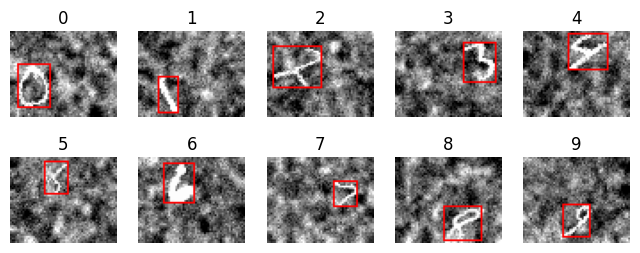

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

for i, ax in enumerate(axes.flat): 
    img, bbox = next((img, label[1:5]) for img, label in train_data if int(label[-1]) == i)
    img_height, img_width = train_data[0][0].shape[-2], train_data[0][0].shape[-1]

    img = (img * 255).byte()

    bbox[0] *= img_width
    bbox[1] *= img_height
    bbox[2] *= img_width
    bbox[3] *= img_height

    bbox = bbox.type(torch.uint8)

    converted_bbox = box_convert(bbox, in_fmt='cxcywh', out_fmt='xyxy')

    img_with_bbox = draw_bounding_boxes(img, converted_bbox.unsqueeze(0), colors='red')
    img_with_bbox  = img_with_bbox.numpy().transpose((1, 2, 0))
    ax.imshow(img_with_bbox, cmap='gray')
    ax.set_title(i)
    ax.axis('off')

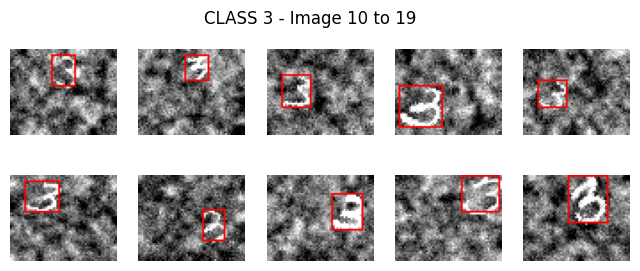

In [11]:
def plot_class(data:torch.tensor, class_label:int, start_idx:int=0) -> None:
    """Plots a subplot with 10 images from a given class, starting at a chosen index"""
    class_images = [img for img, label in data if int(label[-1]) == class_label]
    bboxes = [label[1:5] for img, label in data if int(label[-1]) == class_label]
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

    for i, ax in enumerate(axes.flat):

        idx = start_idx + i
        img = class_images[idx]
        bbox = bboxes[idx]

        img_height, img_width = train_data[0][0].shape[-2], train_data[0][0].shape[-1]

        img = (img * 255).byte()

        bbox[0] *= img_width
        bbox[1] *= img_height
        bbox[2] *= img_width
        bbox[3] *= img_height

        bbox = bbox.type(torch.uint8)

        converted_bbox = box_convert(bbox, in_fmt='cxcywh', out_fmt='xyxy')

        img_with_bbox = draw_bounding_boxes(img, converted_bbox.unsqueeze(0), colors='red')
        img_with_bbox  = img_with_bbox.numpy().transpose((1, 2, 0))
        ax.imshow(img_with_bbox, cmap='gray')
        plt.suptitle(f'CLASS {class_label} - Image {start_idx} to {idx}')
        ax.axis('off')

    plt.show()

plot_class(train_data, 3, 10)

#### Defining a normalizer and a preprocessor TBD

In [12]:
imgs = torch.stack([img for img, _ in train_data])

# Define normalizer
normalizer_pipe = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

# Definer preprocessor including the normalizer
preprocessor = transforms.Compose([
            transforms.ToTensor(),
            normalizer_pipe
        ])

In [13]:
train_data = torch.load('data/localization_train.pt')
val_data = torch.load('data/localization_val.pt')
test_data = torch.load('data/localization_test.pt')

#### Defining the loss function

In [14]:
class LossFn(nn.Module):
    """Custom loss function"""
    def __init__(self):
        super().__init__()
        self.L_a = nn.BCEWithLogitsLoss()  # detection loss
        self.L_b = nn.MSELoss()  # localization loss
        self.L_c = nn.CrossEntropyLoss()  # classification loss

    def forward(self, y_pred, y_true):
        # print(y_pred[0])
        # print(y_true[0])
        condition_tensor = torch.tensor([1.0 if y_pred[0][0] >= 0.5 else 0.0], device=y_pred.device)
        loss = self.L_a(y_pred[:, 0:1], condition_tensor.unsqueeze(0))
        return loss

#### Defining models

In [15]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Define fully connected layers
        self.fc1 = nn.Linear(12*15*64, 15)  # Adjust input size based on your input image size
        self.flat = nn.Flatten()

    
    def forward(self, x):
        # Apply convolutional layers with activation functions
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2, stride=2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2, stride=2)
        out = F.relu(self.conv3(out))
        #out = F.max_pool2d(out, 2)
        # Flatten the output from convolutional layers
        out = self.flat(out)
        # Apply fully connected layers with activation functions
        out = self.fc1(out)

        return out

In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False)

model = MyCNN()

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = LossFn()

In [17]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [18]:
loss = train(
    n_epochs=1,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

AttributeError: 'int' object has no attribute 'size'